## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import librosa.display
import tensorflow as tf
%matplotlib inline

tf.random.set_seed(100)

## Load Data

In [3]:
!pwd

/Users/fengqijie/Desktop/PCG-Classification


In [2]:
AS = np.array([librosa.load(os.path.join("AS", filename), sr=None)[0] for filename in sorted(os.listdir("AS"))], dtype=object)
MR = np.array([librosa.load(os.path.join("MR", filename), sr=None)[0] for filename in sorted(os.listdir("MR"))], dtype=object)
MS = np.array([librosa.load(os.path.join("MS", filename), sr=None)[0] for filename in sorted(os.listdir("MS"))], dtype=object)
MVP = np.array([librosa.load(os.path.join("MVP", filename), sr=None)[0] for filename in sorted(os.listdir("MVP"))], dtype=object)
N = np.array([librosa.load(os.path.join("N", filename), sr=None)[0] for filename in sorted(os.listdir("N"))], dtype=object)

sr = librosa.load(os.path.join("AS", os.listdir("AS")[0]), sr=None)[1]

FileNotFoundError: [Errno 2] No such file or directory: 'AS'

In [ ]:
AS = np.array([(x - np.mean(x)) / np.std(x) for x in AS], dtype='object')
MR = np.array([(x - np.mean(x)) / np.std(x) for x in MR], dtype='object')
MS = np.array([(x - np.mean(x)) / np.std(x) for x in MS], dtype='object')
MVP = np.array([(x - np.mean(x)) / np.std(x) for x in MVP], dtype='object')
N = np.array([(x - np.mean(x)) / np.std(x) for x in N], dtype='object')

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(AS[0], sr=sr)

## Sequence padding

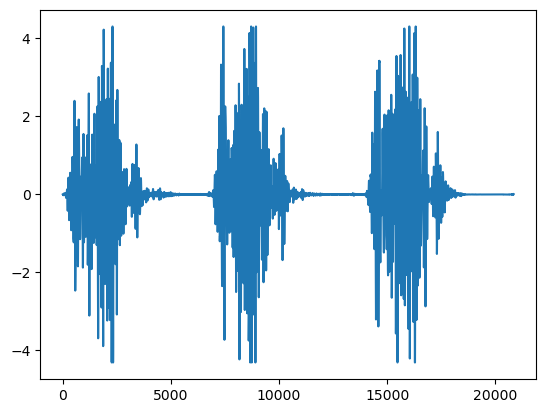

In [5]:
plt.plot(AS[0])

In [6]:
length = [len(x) for x in AS]
length += [len(x) for x in MR]
length += [len(x) for x in MS]
length += [len(x) for x in MVP]
length += [len(x) for x in N]

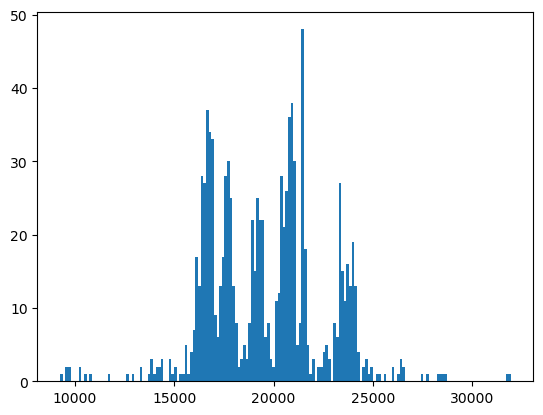

In [7]:
plt.hist(length, bins=170)
plt.show()

In [8]:
MAXLEN = 27500
def pad_sequence(x, maxlen=MAXLEN):
    return tf.keras.utils.pad_sequences(sequences=x, maxlen=maxlen,
                                       dtype='float32', padding='post',
                                       truncating='post')

In [9]:
AS = pad_sequence(AS)
MR = pad_sequence(MR)
MS = pad_sequence(MS)
MVP = pad_sequence(MVP)
N = pad_sequence(N)

In [10]:
# shuffle
AS = np.array(tf.random.shuffle(AS))
MR = np.array(tf.random.shuffle(MR))
MS = np.array(tf.random.shuffle(MS))
MVP = np.array(tf.random.shuffle(MVP))
N = np.array(tf.random.shuffle(N))

Metal device set to: Apple M2 Pro


2024-01-04 21:18:24.597322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 21:18:24.597724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## MFCC feature extraction

In [11]:
def mfcc(x, n_mfcc=30):
    return librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

In [12]:
AS = np.array([mfcc(x) for x in AS])
MR = np.array([mfcc(x) for x in MR])
MS = np.array([mfcc(x) for x in MS])
MVP = np.array([mfcc(x) for x in MVP])
N = np.array([mfcc(x) for x in N])

In [13]:
AS.shape

(200, 30, 54)

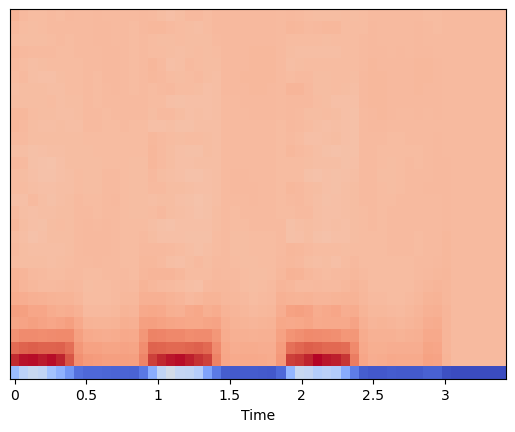

In [14]:
librosa.display.specshow(AS[0], sr=sr, x_axis='time')

## Create dataset

In [17]:
X = np.concatenate((AS, MR, MS, MVP, N))
Y = np.concatenate((np.zeros(200), np.ones(200), 2*np.ones(200), 3*np.ones(200), 4*np.ones(200)))

X_new = np.ones((1, AS.shape[1], AS.shape[2]))
Y_new = np.ones(1)
for i in range(200):
    X_tmp = np.array([X[i], X[200+i], X[400+i], X[600+i], X[800+i]], dtype=np.float32)
    Y_tmp = np.array([Y[i], Y[200+i], Y[400+i], Y[600+i], Y[800+i]], dtype=int)
    X_new = np.concatenate((X_new, X_tmp))
    Y_new = np.concatenate((Y_new, Y_tmp))
    
X_new = np.array(X_new[1:], dtype=np.float32)
Y_new = np.array(Y_new[1:], dtype=int)

## Swap axes

In [18]:
X_new = np.swapaxes(X_new, 1, 2)

In [19]:
X_new[0].shape

(54, 30)

## Split Data

In [14]:
x_test = X_new[0:100]
x_train = X_new[100:]

y_test = Y_new[0:100]
y_train = Y_new[100:]

## Save file

In [20]:
# np.savez("mfcc.npz", x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)
np.savez("mfcc_fixed.npz", X=X_new, Y=Y_new)